In [8]:
from visualizer import get_local
get_local.activate() # 激活visualizer，注意不能在模型文件里激活！

from timm.models import create_model
import model_prune
import models
import torch
import torch.nn as nn
from PIL import Image
import cv2
import numpy as np
from numpy import linalg as LA

import matplotlib.pyplot as plt

from timm.models.vision_transformer import VisionTransformer

model = create_model(
        #'pxdeit_base_patch16_224',
        'deit_base_patch16_384',
        pretrained=False,
        num_classes=1000,
        drop_rate=0.0,
        drop_path_rate=0.1,
        drop_block_rate=None,
        #img_size=224
    )

#checkpoint = torch.load('checkpoint/vit_base_16_224.pth', map_location='cpu')
checkpoint = torch.load('/home/eescut/Documents/ViT_HeatMap/checkpoint/DeiT_base_patch16_394.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [9]:
import torchvision.transforms as T
from timm.models.vision_transformer import VisionTransformer
image = Image.open('cat.jpeg')
patch_size = 16


normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
''' 
transforms = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            normalize,
        ])
'''
transforms = T.Compose([
            #T.Resize(224),
            T.Resize(384),
            T.ToTensor(),
            normalize,
        ])

input_tensor = transforms(image).unsqueeze(0)

w_featmap = input_tensor.shape[-2] // patch_size
h_featmap = input_tensor.shape[-1] // patch_size

input_tensor.shape


torch.Size([1, 3, 384, 384])

In [10]:


with torch.no_grad():

    output = model(input_tensor)
    #print(output[:20])
    predicted_class_idx = output.argmax(-1).item()
    m = nn.Softmax(dim=1)
    print(m(output)[0,predicted_class_idx])

print(predicted_class_idx)

tensor(0.5761)
281


In [42]:
cache = get_local.cache
for i in cache:
    print(i, len(cache[i]))
#print(len(cache['myBlock.random_drop_x']))

dropinput = cache['Attention.forward'][11]
'''
x_input = cache['myBlock.forward'][0]
dropinput = cache['myBlock.drop_low_attn'][0]
droplow = cache['myBlock.drop_low_l2_norm'][0]
print(dropinput.shape)
'''
print(dropinput.shape, type(dropinput))

Attention.forward 24
Attention0.forward 0
myBlock.drop_low_l2_norm 0
myBlock.drop_low_attn 0
myBlock.forward 0
(1, 12, 577, 577) <class 'numpy.ndarray'>


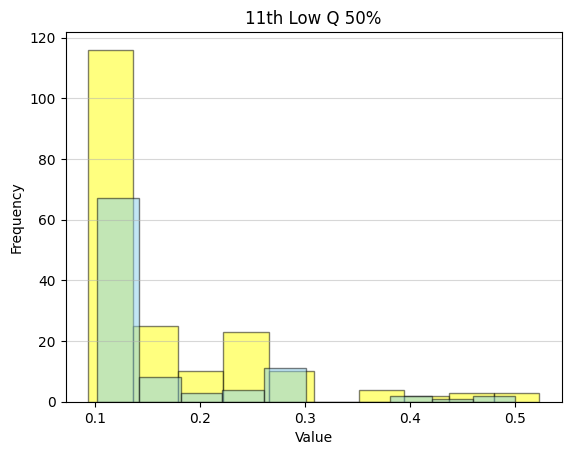

In [ ]:
plt.hist(np.squeeze(LA.norm(x_input[:,1:,:],2, 2)/786), bins=10, alpha=0.5, color='yellow', edgecolor='black')  # Adjust bins as needed
plt.hist(np.squeeze(LA.norm(dropinput[:,1:,:],2,2)/768), bins=10, alpha=0.5, color='skyblue', edgecolor='black')  # Adjust bins as needed

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('11th Low Q 50%')
plt.grid(axis='y', alpha=0.5)

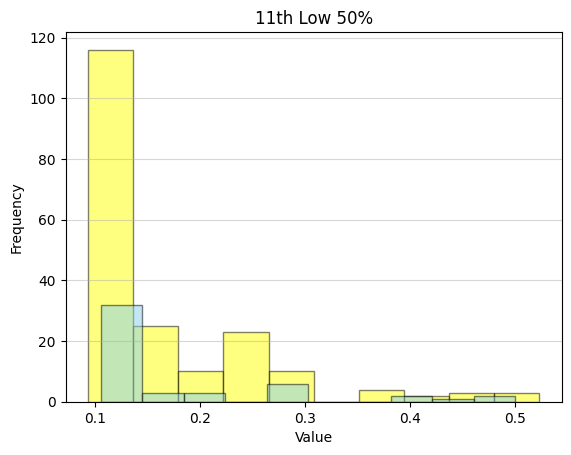

In [ ]:
plt.hist(np.squeeze(LA.norm(x_input[:,1:,:],2, 2)/786), bins=10, alpha=0.5, color='yellow', edgecolor='black')  # Adjust bins as needed
plt.hist(np.squeeze(LA.norm(droplow[:,1:,:],2,2)/768), bins=10, alpha=0.5, color='skyblue', edgecolor='black')  # Adjust bins as needed

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('11th Low 50%')
plt.grid(axis='y', alpha=0.5)

12 heads
torch.Size([12, 576]) tensor(9.9712e-06)
(12, 384, 384)


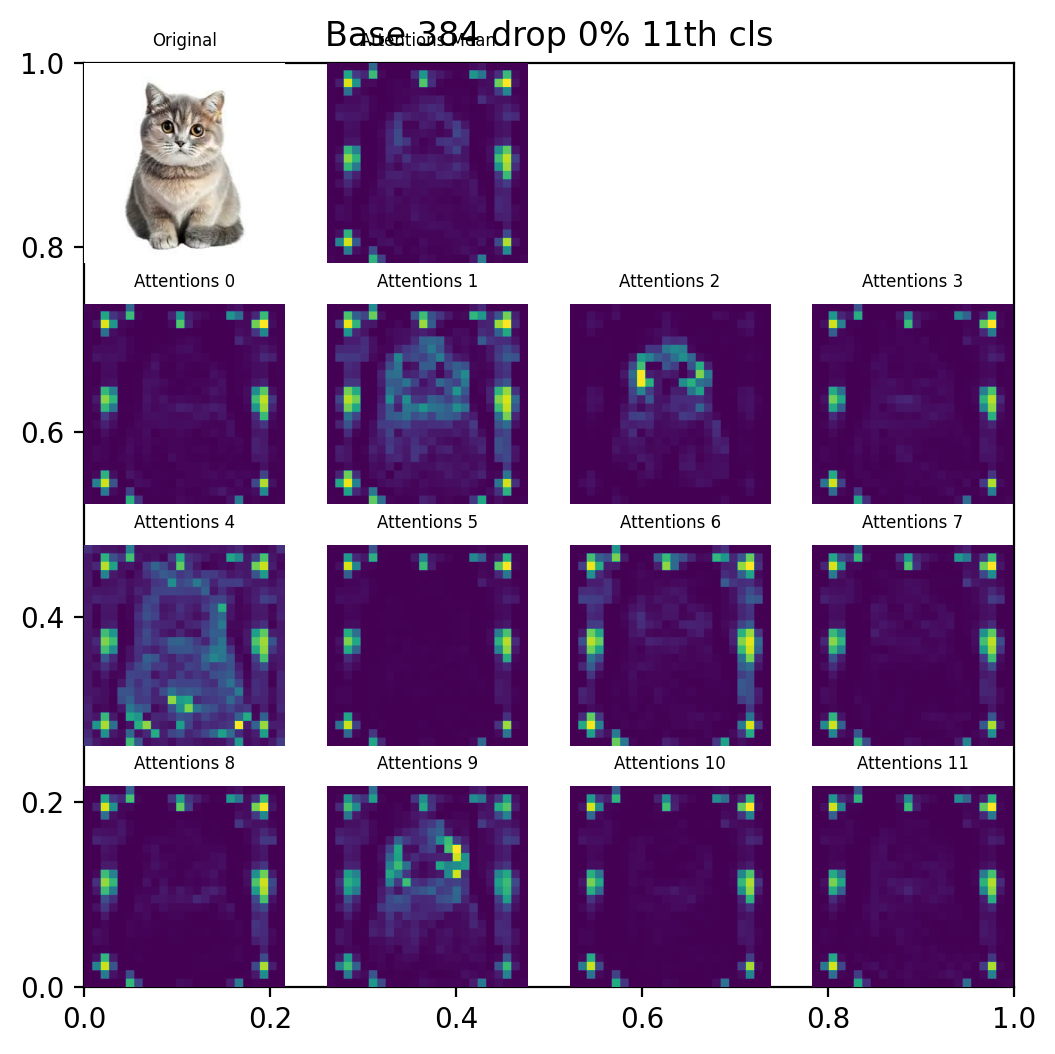

In [43]:
# draw attention maps
# input shape: (1,12,197,197)
attentions = torch.from_numpy(dropinput) 
nh = attentions.shape[1] # number of head
print(nh, 'heads')

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape, attentions[0].min())

# fill to 196
if(attentions.shape[1]<196):
    pass

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions_mean = np.mean(attentions, axis=0)

print(attentions.shape)
plt.figure(figsize=(6,6), dpi=200)
plt.title('Base 384 drop 0% 11th cls')

plt.subplot(4, 4, 1)
plt.title("Original",size=6)
plt.imshow(image)
plt.axis("off")

plt.subplot(4, 4, 2)
plt.title("Attentions Mean",size=6)
plt.imshow(attentions_mean)
plt.axis("off")

for i in range(12):
    plt.subplot(4, 4, i+4+1)
    plt.title("Attentions "+str(i),size=6)
    plt.imshow(attentions[i])
    plt.axis("off")

/tmp/ipykernel_70896/134223898.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, [82.938,82.962,82.864,82.866], 'o-r', color='blue',label='low+scale')
/tmp/ipykernel_70896/134223898.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, [83.002,82.912,82.914,82.918], 'o-r', color='orange', label='key+scale')
/tmp/ipykernel_70896/134223898.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, [82.876,82.984,82.922,82.912], 'o-r', color='pink', label='query+scale')
/tmp/ipykernel_70896/134223898.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The 

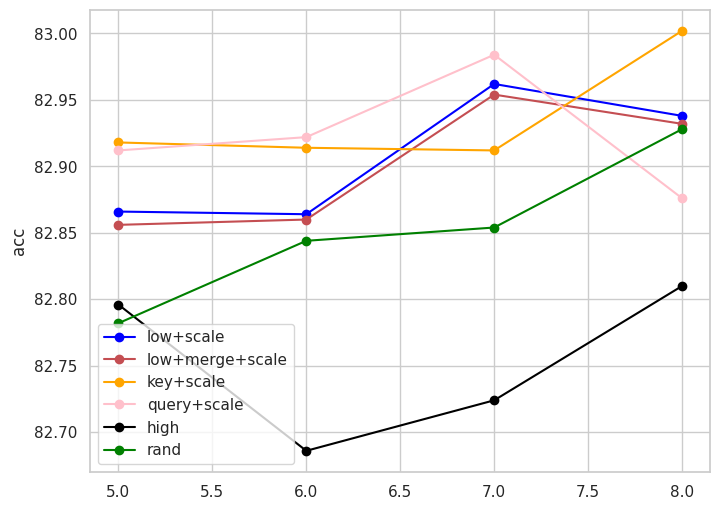

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Optional for styling

# Data as a dictionary (replace with your actual values)
data = {
    'Method': ['low+scale', 'low+merge+scale', 'key+scale', 'query+scale', 'high', 'rand'],
    '8th': [82.938, 82.932, 83.002, 82.876, 82.810, 82.928],
    '7th': [82.962, 82.954, 82.912, 82.984, 82.724, 82.854],
    '6th': [82.864, 82.860, 82.914, 82.922, 82.686, 82.844],
    '5th': [82.866, 82.856, 82.918, 82.912, 82.796, 82.782]
}

import matplotlib.pyplot as plt
x = np.array([8, 7, 6, 5]) 

plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
ax = plt.gca()  # Get the current axes

ax.plot(x, [82.938,82.962,82.864,82.866], 'o-r', color='blue',label='low+scale')
ax.plot(x, [82.932,82.954,82.860,82.856], 'o-r', label='low+merge+scale')
ax.plot(x, [83.002,82.912,82.914,82.918], 'o-r', color='orange', label='key+scale')
ax.plot(x, [82.876,82.984,82.922,82.912], 'o-r', color='pink', label='query+scale')
ax.plot(x, [82.810,82.724,82.686,82.796], 'o-r', color='black', label='high')
ax.plot(x, [82.928,82.854,82.844,82.782], 'o-r', color='green', label='rand')
plt.ylabel('acc')
ax.legend()
plt.show()
